In [1]:
!pip install torchvision

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms   
from torchvision import datasets
from torch.utils.data import DataLoader 
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from numpy import argmax
from numpy import vstack

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
training_data = datasets.MNIST(
                                root="data",
                                train=True,
                                download=True
)

test_data = datasets.MNIST(
                                root="data",
                                train=False,
                                download=True
)

train_dataloader = DataLoader(    training_data, 
                                  batch_size=64, 
                                  shuffle=True
                             )
test_dataloader = DataLoader(     test_data, 
                                  batch_size=64, 
                                  shuffle=True
                            )

In [5]:
# define model
inc = 28*28
outc = 128
res = 10

In [6]:
#полносвязная сеть
class FCnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.flat = nn.Flatten()
            self.fc1 = nn.Linear(inc, outc )
            self.fc2 = nn.Linear(outc, res)
            self.dp1 = nn.Dropout(0.2)

        def forward(self, x):
            x = self.flat(x) # 28*28
            x = self.fc1(x) # 28*28*128
            x = F.relu(x)
            x = self.dp1(x)
            x = self.fc2(x) # 128*10
            output = F.softmax(x, dim=1)
            return output


In [7]:
#глубокая сверточная сеть
class   DeepConvnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 8, 5) 
            self.mp1 = nn.MaxPool2d(2) 
            self.act1 = nn.Tanh()
            self.conv2 = nn.Conv2d(8, 24, 3) 
            self.flat = nn.Flatten()
            self.fc1 = nn.Linear(600, 128)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, 10)
            self.act2 = nn.Softmax()

        def forward(self, x):
            x = self.conv1(x) #out 8x24x24
            x = self.mp1(x) #out 8x12x12
            x = self.act1(x)
            x = self.conv2(x) #out 16x10x10
            x = self.mp1(x) #out 16x5x5
            x = self.act1(x)
            x = self.flat(x) #out 400
            x = self.fc1(x) #out 128
            x = self.act1(x)
            x = self.fc2(x) #out 64
            x = self.act1(x)
            x = self.fc3(x) #out 10
            output = self.act2(x)
            return output

In [8]:
class SimpleCustomBatch:
    def __init__(self, data):
        transposed_data = list(zip(*data))
        convert = transforms.ToTensor()
        inp = tuple(map(lambda x: convert(x), transposed_data[0]))
        tgt = tuple(map(lambda x: torch.asarray(x), transposed_data[1]))
        self.inp = torch.stack(inp, 0)
        self.tgt = torch.stack(tgt, 0)

    def pin_memory(self):
        self.inp = self.inp.pin_memory()
        self.tgt = self.tgt.pin_memory()
        return self

In [9]:
def collate_wrapper(batch):
    return SimpleCustomBatch(batch)

In [10]:
# prepare data  Train , Test
training_data = datasets.MNIST(
                                root="data",
                                train=True,
                                download=True
)

test_data = datasets.MNIST(
                                root="data",
                                train=False,
                                download=True
)

train_dataloader = DataLoader(    training_data, 
                                  batch_size=64, 
                                  collate_fn = collate_wrapper,
                                  shuffle=True
                             )

test_dataloader = DataLoader(     test_data, 
                                  batch_size=512, 
                                  collate_fn = collate_wrapper,  
                                  shuffle=True
                            )
     

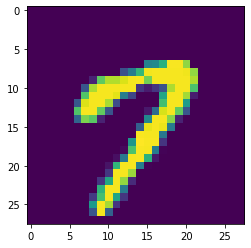

In [11]:
from matplotlib.pyplot import imshow
imshow(training_data.__getitem__(15)[0])

In [12]:
# train model
from torch.nn.modules.loss import CrossEntropyLoss, MSELoss
from torch.optim import SGD
from torchvision import transforms

In [13]:
def train_model(train_ds, model):
    loss_fn = CrossEntropyLoss(reduction='none')
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(1):
          for i, data in enumerate(train_ds):
            inputs = data.inp.to(torch.float32)
            labels = data.tgt.to(torch.float32)
            labels = torch.tensor(labels, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.mean().backward()
            optimizer.step()
    print('Epoch {} loss equals : {}'.format( epoch, loss.mean() ))
    return loss.mean().detach().numpy()

In [14]:
def evaluate(test_ds, model):
    preds, actuals = list(), list()
    for i, data in enumerate(test_ds):
        inputs = data.inp.to(torch.float32)
        labels = data.tgt.to(torch.float32)
        y = model(inputs)
        y = y.detach().numpy()
        actual = labels.numpy()
        y = argmax(y, axis=1)
        actual = actual.reshape((len(actual), 1))
        y = y.reshape((len(y), 1))

        preds.append(y)
        actuals.append(actual)

        preds, actuals = vstack(preds), vstack(actuals)
        acc = accuracy_score(actuals, preds)
        return acc

In [15]:
net = FCnet()

In [16]:
train_model(train_dataloader, net)

/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2078521555.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.624010443687439


array(1.6240104, dtype=float32)

In [17]:
loss_list = list()
epoch = list()
acc_list = list()

for i in range(10):
    epoch.append(i)
    loss_list.append(train_model(train_dataloader, net))
    res = []
    for j in range(5):
        res.append(evaluate(test_dataloader,net))

    print(f'epoch: {i} , accuracy: {np.mean(res)}')
    acc_list.append(np.mean(res))

/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2078521555.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.6117758750915527
epoch: 0 , accuracy: 0.90234375


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2078521555.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.6319994926452637
epoch: 1 , accuracy: 0.9125


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2078521555.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.559495449066162
epoch: 2 , accuracy: 0.915234375


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2078521555.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.5308866500854492
epoch: 3 , accuracy: 0.91640625


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2078521555.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.5112005472183228
epoch: 4 , accuracy: 0.91484375


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2078521555.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.5135180950164795
epoch: 5 , accuracy: 0.925390625


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2078521555.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.5698803663253784
epoch: 6 , accuracy: 0.925


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2078521555.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.5119953155517578
epoch: 7 , accuracy: 0.932421875


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2078521555.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.505581021308899
epoch: 8 , accuracy: 0.93984375


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2078521555.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.476839303970337
epoch: 9 , accuracy: 0.940234375


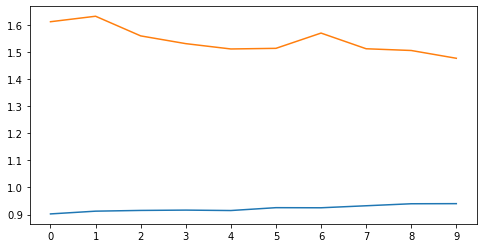

In [18]:
fig , ax = plt.subplots(figsize=(8,4))
plt.plot(epoch, acc_list)
plt.plot(epoch, loss_list)
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

In [19]:
dnet = DeepConvnet()

In [20]:
def train_dmodel(train_ds, model):
    loss_fn = CrossEntropyLoss(reduction='none')
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(1):
        for i, data in enumerate(train_ds):
            inputs = data.inp.to(torch.float32)
            labels = data.tgt.to(torch.float32)
            labels = torch.tensor(labels, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.mean().backward()
            optimizer.step()
    print('Epoch {} loss equals : {}'.format( epoch, loss.mean() ))
    return loss.mean().detach().numpy()
     

In [21]:
dloss_list = list()
depoch = list()
dacc_list = list()

for i in range(10):
    depoch.append(i)
    dloss_list.append(train_dmodel(train_dataloader, net))
    res = []
    for j in range(5):
        res.append(evaluate(test_dataloader,net))
  
    print(f'epoch: {i} , accuracy: {np.mean(res)}')
    dacc_list.append(np.mean(res))

/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2025828778.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.556881070137024
epoch: 0 , accuracy: 0.937109375


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2025828778.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.5395128726959229
epoch: 1 , accuracy: 0.943359375


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2025828778.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.5478503704071045
epoch: 2 , accuracy: 0.945703125


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2025828778.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.5549813508987427
epoch: 3 , accuracy: 0.9421875


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2025828778.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.4897524118423462
epoch: 4 , accuracy: 0.94375


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2025828778.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.5090731382369995
epoch: 5 , accuracy: 0.946875


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2025828778.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.5485494136810303
epoch: 6 , accuracy: 0.95078125


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2025828778.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.4927902221679688
epoch: 7 , accuracy: 0.94609375


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2025828778.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.6247942447662354
epoch: 8 , accuracy: 0.955078125


/var/folders/04/p9n_pr6j0n971vm_1r43l7400000gn/T/ipykernel_5638/2025828778.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Epoch 0 loss equals : 1.5335496664047241
epoch: 9 , accuracy: 0.949609375


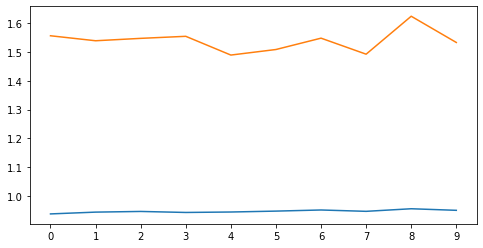

In [22]:
fig , ax1 = plt.subplots(figsize=(8,4))
plt.plot(depoch, dacc_list)
plt.plot(depoch, dloss_list)
ax1.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

Cверточная сеть, показывает результ лучше, чем полносвязная сеть